In [1]:
import mxnet as mx
from mxnet import gluon, autograd ,nd
from mxnet.gluon import nn, utils
import numpy as np
import os, sys
import tarfile
import matplotlib as mpl
from matplotlib import pyplot as plt

from datetime import datetime
import time
import logging


In [2]:
#Define hyperparameter
epochs = 100
batch_size = 64
latent_z_size = 100

use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5

#Define image size
nc = 3
ngf = 64
ndf = 64

In [3]:
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)

In [4]:
target_wd = 64
target_ht = 64
img_list = []

def transform(data, target_wd, target_ht):
    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    # transpose from (target_wd, target_ht, 3)
    # to (3, target_wd, target_ht)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

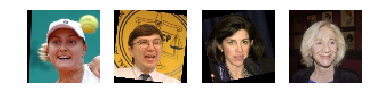

In [5]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

In [6]:
# build the generator
class netGenerator(gluon.HybridBlock):
    def __init__(self,**kwargs):
        super(netGenerator,self).__init__(**kwargs)
        with self.name_scope():
            self.convT1 = nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias = False)
            self.bn1 = nn.BatchNorm()
            self.convT2 = nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False)
            self.bn2 = nn.BatchNorm()
            self.convT3 = nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False)
            self.bn3 = nn.BatchNorm()
            self.convT4 = nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False)
            self.bn4 = nn.BatchNorm()
            self.convT5 = nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False)
                        
    def forward(self,x,view=False):
        self.view = view
        x = self.convT1(x)
        if self.view :
            print("1st convT output shape:{s}".format(s=x.shape))
        x = nd.relu(x)
        x = self.bn1(x)
        
        x = self.convT2(x)
        if self.view :
            print("2nd convT output shape:{s}".format(s=x.shape))
        x = nd.relu(x)
        x = self.bn2(x)
        
        x = self.convT3(x)
        if self.view :
            print("3rd convT output shape:{s}".format(s=x.shape))
        x = nd.relu(x)
        x = self.bn3(x)
        
        x = self.convT4(x)
        if self.view :
            print("4th convT output shape:{s}".format(s=x.shape))
        x = nd.relu(x)
        x = self.bn4(x)
        
        x = self.convT5(x)
        if self.view :
            print("5th convT output shape:{s}".format(s=x.shape))
        x = nd.tanh(x)
            
        return x
            

In [7]:
# build the discriminator
class netDiscremeter(gluon.HybridBlock):
    def __init__(self,**kwargs):
        super(netDiscremeter,self).__init__(**kwargs)
        with self.name_scope():
            self.conv1 =  nn.Conv2D(ndf, 4, 2, 1, use_bias=False)
            self.relu1 = nn.LeakyReLU(0.2)
            self.conv2 = nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False)
            self.bn1 = nn.BatchNorm()
            self.relu2 = nn.LeakyReLU(0.2)
            self.conv3 = nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False)
            self.bn2 = nn.BatchNorm()
            self.relu3 = nn.LeakyReLU(0.2)
            self.conv4 = nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False)
            self.bn3 = nn.BatchNorm()
            self.relu4 = nn.LeakyReLU(0.2)
            self.conv5 = nn.Conv2D(1, 4, 1, 0, use_bias=False)

            
    def forward(self,x,view=False):
        self.view = view
        x = self.conv1(x)
        if self.view :
            print("1st conv output shape:{s}".format(s=x.shape))
        x = self.relu1(x)
        
        x = self.conv2(x)
        if self.view :
            print("2nd  conv output shape:{s}".format(s=x.shape))
        x = self.bn1(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        if self.view :
            print("3rd  conv output shape:{s}".format(s=x.shape))
        x = self.bn2(x)
        x = self.relu3(x)
        
        x = self.conv4(x)
        if self.view :
            print("4th  conv output shape:{s}".format(s=x.shape))
        x = self.bn3(x)
        x = self.relu4(x)
        
        x = self.conv5(x)
        if self.view :
            print("5th  conv output shape:{s}".format(s=x.shape))
        
        return x
        


In [8]:
netG = netGenerator()
netD = netDiscremeter()

In [9]:
netG.collect_params

<bound method Block.collect_params of netGenerator(
  (convT1): Conv2DTranspose(512 -> 0, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=None)
  (convT2): Conv2DTranspose(256 -> 0, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=None)
  (convT3): Conv2DTranspose(128 -> 0, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=None)
  (convT4): Conv2DTranspose(64 -> 0, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=None)
  (convT5): Conv2DTranspose(3 -> 0, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)>

In [10]:
netD.collect_params

<bound method Block.collect_params of netDiscremeter(
  (conv1): Conv2D(None -> 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (relu1): LeakyReLU(0.2)
  (conv2): Conv2D(None -> 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=None)
  (relu2): LeakyReLU(0.2)
  (conv3): Conv2D(None -> 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=None)
  (relu3): LeakyReLU(0.2)
  (conv4): Conv2D(None -> 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=None)
  (relu4): LeakyReLU(0.2)
  (conv5): Conv2D(None -> 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)>

In [11]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})


In [12]:
##Test network
dis_data = nd.ones((3,3,64,64))
dis_data = dis_data/255.0

gen_data = nd.ones((3,100,1,1))

In [13]:
outG = netG.forward(gen_data.as_in_context(ctx),view=True) ## setting the device info

1st convT output shape:(3, 512, 4, 4)
2nd convT output shape:(3, 256, 8, 8)
3rd convT output shape:(3, 128, 16, 16)
4th convT output shape:(3, 64, 32, 32)
5th convT output shape:(3, 3, 64, 64)


In [14]:
outD = netD.forward(dis_data.as_in_context(ctx),view=True) ## setting the device info

1st conv output shape:(3, 64, 32, 32)
2nd  conv output shape:(3, 128, 16, 16)
3rd  conv output shape:(3, 256, 8, 8)
4th  conv output shape:(3, 512, 4, 4)
5th  conv output shape:(3, 1, 1, 1)


In [15]:
outG.shape

(3, 3, 64, 64)

In [16]:
outD.shape

(3, 1, 1, 1)

In [17]:
#define loss metric
real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

In [18]:
iter_loss = dict()
iter_loss['dis'] =[]
iter_loss['gen'] =[]

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = batch.data[0].as_in_context(ctx)
        
        #Generate random data
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

        with autograd.record():
            # train with real image
            output = netD.forward(data,view=False).reshape((-1, 1))
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            # train with fake image
            fake = netG.forward(latent_z,view=False)
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = netG(latent_z)
            output = netD(fake).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch.data[0].shape[0])
        
        #save dis/gen loss
        if iter % 50 == 0:
            iter_loss['dis'].append(nd.mean(errD).asscalar())
            iter_loss['gen'].append(nd.mean(errG).asscalar())
        # Print log infomation every ten batches
        if iter % 100 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()

INFO:root:speed: 177.97832717165878 samples/s
INFO:root:discriminator loss = 1.556993, generator loss = 2.818384, binary training acc = 0.484375 at iter 0 epoch 0
INFO:root:speed: 792.9279694686253 samples/s
INFO:root:discriminator loss = 0.120692, generator loss = 7.771504, binary training acc = 0.975480 at iter 100 epoch 0
INFO:root:speed: 769.2772671911047 samples/s
INFO:root:discriminator loss = 0.105495, generator loss = 3.801334, binary training acc = 0.953125 at iter 200 epoch 0
INFO:root:speed: 758.2344171489746 samples/s
INFO:root:discriminator loss = 0.158382, generator loss = 4.078608, binary training acc = 0.992188 at iter 0 epoch 1
INFO:root:speed: 776.1794576714223 samples/s
INFO:root:discriminator loss = 0.567254, generator loss = 2.111970, binary training acc = 0.899985 at iter 100 epoch 1
INFO:root:speed: 650.4356810378458 samples/s
INFO:root:discriminator loss = 0.802870, generator loss = 7.439206, binary training acc = 0.890197 at iter 200 epoch 1
INFO:root:speed: 65

INFO:root:discriminator loss = 0.395297, generator loss = 3.911670, binary training acc = 0.850630 at iter 200 epoch 16
INFO:root:speed: 751.8000095222892 samples/s
INFO:root:discriminator loss = 0.566144, generator loss = 3.299504, binary training acc = 0.945312 at iter 0 epoch 17
INFO:root:speed: 744.0275176212003 samples/s
INFO:root:discriminator loss = 0.533035, generator loss = 2.769084, binary training acc = 0.837562 at iter 100 epoch 17
INFO:root:speed: 758.0331468622308 samples/s
INFO:root:discriminator loss = 0.508679, generator loss = 1.617503, binary training acc = 0.844605 at iter 200 epoch 17
INFO:root:speed: 744.8471267238269 samples/s
INFO:root:discriminator loss = 0.620537, generator loss = 3.378149, binary training acc = 0.882812 at iter 0 epoch 18
INFO:root:speed: 774.3211335210227 samples/s
INFO:root:discriminator loss = 0.564406, generator loss = 2.141973, binary training acc = 0.856281 at iter 100 epoch 18
INFO:root:speed: 720.9921088113797 samples/s
INFO:root:disc

INFO:root:discriminator loss = 0.444620, generator loss = 2.872645, binary training acc = 0.889233 at iter 100 epoch 33
INFO:root:speed: 709.7711686938128 samples/s
INFO:root:discriminator loss = 0.163861, generator loss = 3.780554, binary training acc = 0.907222 at iter 200 epoch 33
INFO:root:speed: 747.1691374175412 samples/s
INFO:root:discriminator loss = 0.228186, generator loss = 4.001406, binary training acc = 0.976562 at iter 0 epoch 34
INFO:root:speed: 747.1025933615733 samples/s
INFO:root:discriminator loss = 0.233124, generator loss = 3.733389, binary training acc = 0.885133 at iter 100 epoch 34
INFO:root:speed: 749.5705505711788 samples/s
INFO:root:discriminator loss = 0.210142, generator loss = 4.050465, binary training acc = 0.916278 at iter 200 epoch 34
INFO:root:speed: 727.238743376066 samples/s
INFO:root:discriminator loss = 0.259527, generator loss = 3.886281, binary training acc = 0.968750 at iter 0 epoch 35
INFO:root:speed: 743.9409138400738 samples/s
INFO:root:discr

INFO:root:discriminator loss = 0.163282, generator loss = 4.055188, binary training acc = 0.984375 at iter 0 epoch 50
INFO:root:speed: 712.8358728961639 samples/s
INFO:root:discriminator loss = 0.154647, generator loss = 4.547786, binary training acc = 0.981436 at iter 100 epoch 50
INFO:root:speed: 728.2844600717336 samples/s
INFO:root:discriminator loss = 0.124760, generator loss = 3.857604, binary training acc = 0.983714 at iter 200 epoch 50
INFO:root:speed: 739.611826715637 samples/s
INFO:root:discriminator loss = 0.187948, generator loss = 5.758508, binary training acc = 0.992188 at iter 0 epoch 51
INFO:root:speed: 745.9358424293622 samples/s
INFO:root:discriminator loss = 0.121643, generator loss = 3.749448, binary training acc = 0.990795 at iter 100 epoch 51
INFO:root:speed: 726.5399882534759 samples/s
INFO:root:discriminator loss = 0.121103, generator loss = 4.807024, binary training acc = 0.908232 at iter 200 epoch 51
INFO:root:speed: 731.0871333131794 samples/s
INFO:root:discr

INFO:root:discriminator loss = 0.056873, generator loss = 4.705846, binary training acc = 0.992226 at iter 200 epoch 66
INFO:root:speed: 713.4061067363324 samples/s
INFO:root:discriminator loss = 0.052061, generator loss = 5.531677, binary training acc = 1.000000 at iter 0 epoch 67
INFO:root:speed: 728.9588616274491 samples/s
INFO:root:discriminator loss = 0.077349, generator loss = 5.185529, binary training acc = 0.995050 at iter 100 epoch 67
INFO:root:speed: 745.3496933196723 samples/s
INFO:root:discriminator loss = 0.101010, generator loss = 4.670506, binary training acc = 0.922264 at iter 200 epoch 67
INFO:root:speed: 741.4913941456435 samples/s
INFO:root:discriminator loss = 0.153028, generator loss = 4.826136, binary training acc = 0.984375 at iter 0 epoch 68
INFO:root:speed: 750.7592070524008 samples/s
INFO:root:discriminator loss = 0.357556, generator loss = 6.501115, binary training acc = 0.970452 at iter 100 epoch 68
INFO:root:speed: 743.8852506262886 samples/s
INFO:root:disc

INFO:root:discriminator loss = 0.042828, generator loss = 5.271354, binary training acc = 0.999768 at iter 100 epoch 83
INFO:root:speed: 707.5840566835983 samples/s
INFO:root:discriminator loss = 0.036655, generator loss = 5.254122, binary training acc = 0.999534 at iter 200 epoch 83
INFO:root:speed: 746.5457518702896 samples/s
INFO:root:discriminator loss = 0.051525, generator loss = 6.634553, binary training acc = 1.000000 at iter 0 epoch 84
INFO:root:speed: 742.9525862904052 samples/s
INFO:root:discriminator loss = 0.423634, generator loss = 4.509125, binary training acc = 0.873608 at iter 100 epoch 84
INFO:root:speed: 727.232832772087 samples/s
INFO:root:discriminator loss = 0.117270, generator loss = 5.113098, binary training acc = 0.889420 at iter 200 epoch 84
INFO:root:speed: 735.6068804687093 samples/s
INFO:root:discriminator loss = 0.182392, generator loss = 5.777520, binary training acc = 1.000000 at iter 0 epoch 85
INFO:root:speed: 736.5898965507779 samples/s
INFO:root:discr

/home/seunghwan/work/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


/home/seunghwan/work/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


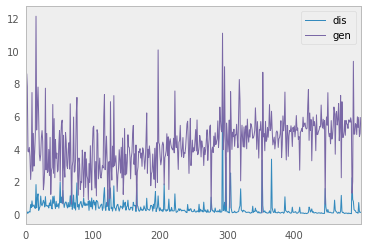

In [19]:
#generator/discriminator loss plot
import pandas as pd
%matplotlib inline 
pd.options.display.mpl_style = 'default'
new_style = {'grid': False}
mpl.rc('axes', **new_style)
data = pd.DataFrame.from_dict(iter_loss)
data.plot()

/home/seunghwan/work/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


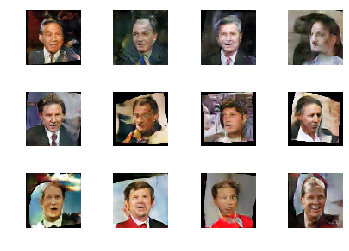

In [20]:
num_image = 12
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    img = netG(latent_z)
    plt.subplot(3,4,i+1)
    visualize(img[0])
plt.show()

/home/seunghwan/work/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


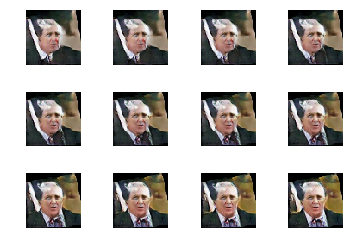

In [21]:
num_image = 12
latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
step = 0.05
for i in range(num_image):
    img = netG(latent_z)
    plt.subplot(3,4,i+1)
    visualize(img[0])
    latent_z += 0.05
plt.show()